In [1]:
%load_ext autoreload
%autoreload 2

In [197]:
import torch
from torch import nn
from torch.nn import functional as F
#from torchdiffeq import odeint
from zuko.utils import odeint
import numpy as np

In [4]:
def get_time_embedding(timesteps, embedding_dim, max_positions=2000):
    # Code from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    assert len(timesteps.shape) == 1
    timesteps = timesteps * max_positions
    half_dim = embedding_dim // 2
    emb = np.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb


class Encoder(nn.Module):
    def __init__(self, input_size=3, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.in_fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.t_fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.ReLU(),
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x, t):
        x = self.in_fc(x)
        t = self.t_fc(get_time_embedding(t, self.hidden_size)).unsqueeze(1).expand_as(x)
        return self.fc(torch.cat((x, t), dim=-1))

In [105]:
class CatFlow(nn.Module):
    def __init__(
        self,
        eps: float = 1e-5,
    ) -> None:
        """
        Constructor of the CatFlow model.

        Args:
            config (dict): Configuration of the model.
            dataset_infos (QM9infos): Information about the dataset.
            domain_features (ExtraMolecularFeatures): Extra molecular features to append to the input.
            device (torch.device): Device to run the model.
            eps (float): Epsilon value to avoid numerical instability. Default value is 1e-5.
        """
        super(CatFlow, self).__init__()
        
        self.eps = eps
        # Limit distribution for the noise
        self.encoder = Encoder()
        
    def sample_simplex(self, *sizes, device='cpu', eps=1e-4):
        """
        Uniformly sample from a simplex.
        :param sizes: sizes of the Tensor to be returned
        :param device: device to put the Tensor on
        :param eps: small float to avoid instability
        :return: Tensor of shape sizes, with values summing to 1
        """
        x = torch.empty(*sizes, device=device, dtype=torch.float).exponential_(1)
        p = x / x.sum(dim=-1, keepdim=True)
        p = p.clamp(eps, 1 - eps)
        return p / p.sum(dim=-1, keepdim=True)

    def sample_time(self, batch_size) -> torch.tensor:

        return torch.rand(batch_size)


    def forward(
        self,
        x, t
    ) -> torch.tensor:

        return F.softmax(self.encoder(x, t), dim=-1)

    def vector_field(
        self,
        t: float,
        x,
    ) -> torch.tensor:

        print(f"Current step: {t}")
        t_old = t
        t = torch.tensor([t], dtype=torch.float).repeat(1000)
        if t.dim() == 0:
            t = t.unsqueeze(0)

        inferred_state = self.forward(x.reshape(1000, 1, 3), t).squeeze(1)
        #print(f"Shape of inferred state: {inferred_state.shape}")
        #print(f"Shape of x: {x.shape}")
        node_vector_field = (inferred_state - x) / (1 - t_old + self.eps)
        return node_vector_field

    def sampling(
        self,
    ) -> torch.tensor:

        noise = self.sample_simplex(1000, 3)
        #noise = torch.randn(1000, 3)
        # Run the ODE solver to perform the integration of the vector field
        # final_state = odeint(
        #     lambda t, x: self.vector_field(t, x),
        #     noise,
        #     t=torch.linspace(0.01, 0.99, 1000 + 1, dtype=torch.float),
        #     atol=1e-5,
        #     rtol=1e-5,
        # )
        final_state = odeint(
            f=self.vector_field,
            x=noise,
            t0=0.,
            t1=1,
            phi=self.parameters(),
        )
        return final_state


In [495]:
from torch import optim

def train_catflow(model, n_epoch=2000, lr=1e-4, log_epoch=200):
    device = torch.device('cpu')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #loss_f = CrossEntropyMetric()
    best_loss = 1e9
    for epoch in range(n_epoch):
        model.train()
        optimizer.zero_grad()
        # Ground truth is X
        # Sample t
        t = model.sample_time(X.shape[0])
        if t.dim() == 0:
            t = t.unsqueeze(0)
        # Sample noise
        noise = model.sample_simplex(X.shape)
        #noise = torch.randn(X.shape)
        # Compute x_t
        x_t = (1 - t[:, None]) * noise + t[:, None] * X
        #print('1', x_t.shape)
        #print('2', X.shape)
        encoded = model(x_t.reshape(1000, 1, 3).to(device), t.to(device))
        # MSE loss
        loss = F.mse_loss(encoded.squeeze(1), X)
        # loss = F.binary_cross_entropy_with_logits(encoded.squeeze(1), X)
        # loss
        # loss = loss_f(F.softmax(encoded.reshape(1000, -1), dim=-1), X.reshape(1000, -1))    
        print(f"Loss: {loss}")
        # if best_loss > loss:
        #     best_loss = loss
        #     best_model = model.state_dict()
        loss.backward()
        optimizer.step()
    print('Done!')
    return 0#best_model

In [496]:
model = CatFlow()
best_model = train_catflow(model, n_epoch=2000, lr=1e-3, log_epoch=200)

Loss: 0.03091421164572239
Loss: 0.02877725660800934
Loss: 0.027426553890109062
Loss: 0.02633209154009819
Loss: 0.026022061705589294
Loss: 0.0264431219547987
Loss: 0.025936294347047806
Loss: 0.025433367118239403
Loss: 0.025250498205423355
Loss: 0.024952972307801247
Loss: 0.024398256093263626
Loss: 0.023968562483787537
Loss: 0.023720398545265198
Loss: 0.02299898862838745
Loss: 0.022555537521839142
Loss: 0.021710233762860298
Loss: 0.021052932366728783
Loss: 0.020978029817342758
Loss: 0.020131243392825127
Loss: 0.019640251994132996
Loss: 0.02002781443297863
Loss: 0.020261144265532494
Loss: 0.02014930173754692
Loss: 0.020073315128684044
Loss: 0.01900354027748108
Loss: 0.019210301339626312
Loss: 0.019262295216321945
Loss: 0.01807299442589283
Loss: 0.01895071193575859
Loss: 0.019460488110780716
Loss: 0.018977735191583633
Loss: 0.018466629087924957
Loss: 0.01811809465289116
Loss: 0.017985669896006584
Loss: 0.017844228073954582
Loss: 0.017508985474705696
Loss: 0.016771843656897545
Loss: 0.01681

In [497]:
torch.save(model.state_dict(), 'model.pth')

In [106]:
catflow = CatFlow()
catflow.load_state_dict(torch.load('model.pth'))

final_state = catflow.sampling()

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_93098/1941963956.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Current step: 0.0
Current step: 0.20000000298023224
Current step: 0.30000001192092896
Current step: 0.800000011920929
Current step: 0.8888888955116272
Current step: 1.0
Current step: 1.0
Current step: 0.0
Current step: 0.020000001415610313
Current step: 0.030000001192092896
Current step: 0.08000000566244125
Current step: 0.08888889104127884
Current step: 0.10000000149011612
Current step: 0.10000000149011612
Current step: 0.0
Current step: 0.009430109523236752
Current step: 0.01414516381919384
Current step: 0.037720438092947006
Current step: 0.041911594569683075
Current step: 0.047150544822216034
Current step: 0.047150544822216034
Current step: 0.0
Current step: 0.004031903576105833
Current step: 0.006047855131328106
Current step: 0.016127614304423332
Current step: 0.017919570207595825
Current step: 0.020159516483545303
Current step: 0.020159516483545303
Current step: 0.0
Current step: 0.002322499407455325
Current step: 0.003483748994767666
Current step: 0.0092899976298213
Current step:

In [107]:
final_state = final_state.detach().numpy()

In [108]:
final_state

array([[0.2795269 , 0.02870269, 0.6917704 ],
       [0.39906025, 0.29485703, 0.30608273],
       [0.52903795, 0.35272753, 0.11823458],
       ...,
       [0.52518487, 0.34824884, 0.1265664 ],
       [0.48906958, 0.45451385, 0.05641656],
       [0.4235786 , 0.07586715, 0.5005543 ]], dtype=float32)

In [109]:
final_state.shape

(1000, 3)

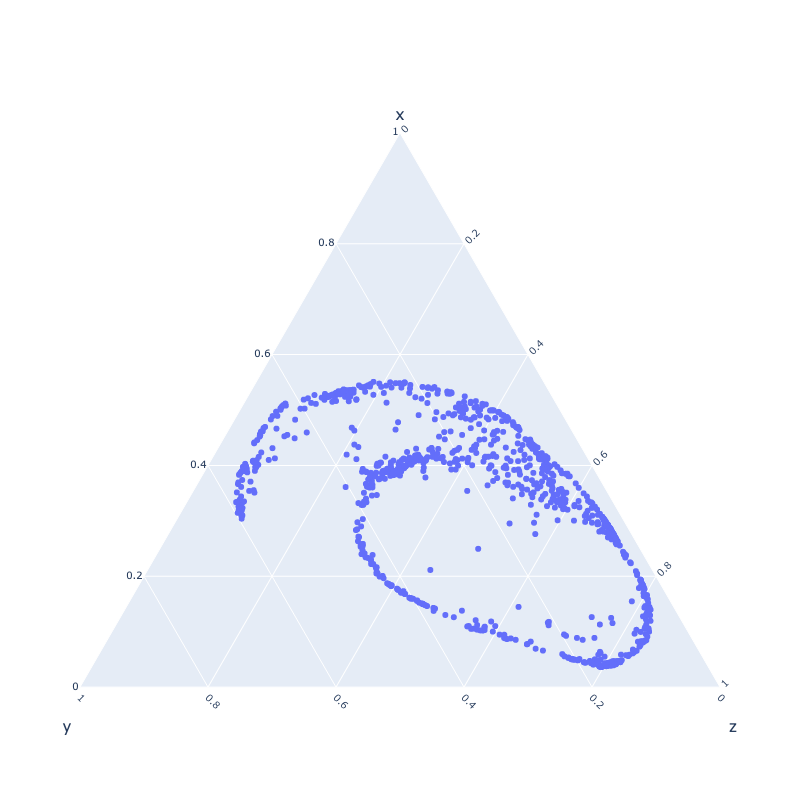

In [110]:
plot_ternary(final_state[:, 0], final_state[:, 1], final_state[:, 2])

# Dirichlet FM


In [510]:
from torch import optim
import scipy

def train_dirichletFM(model, n_epoch=2000, lr=1e-4, log_epoch=200):
    device = torch.device('cpu')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #loss_f = CrossEntropyMetric()
    best_loss = 1e9
    for epoch in range(n_epoch):
        model.train()
        optimizer.zero_grad()
        # Ground truth is X
        # Sample t
        t = torch.from_numpy(1 + scipy.stats.expon().rvs(size=1000) * 2).float()
        alphas_ = torch.ones(1000, 3)
        alphas_ = alphas_ + X * (t[:,None] - 1)
        x_t = torch.distributions.Dirichlet(alphas_).sample()
        if t.dim() == 0:
            t = t.unsqueeze(0)
        # Sample noise
        # noise = model.sample_simplex(X.shape)
        #noise = torch.randn(X.shape)
        # Compute x_t
        # # x_t = (1 - t[:, None]) * noise + t[:, None] * X
        #print('1', x_t.shape)
        #print('2', X.shape)
        encoded = model(x_t.reshape(1000, 1, 3).to(device), t.to(device))
        # MSE loss
        loss = F.mse_loss(encoded.squeeze(1), X)
        # loss = F.binary_cross_entropy_with_logits(encoded.squeeze(1), X)
        # loss
        # loss = loss_f(F.softmax(encoded.reshape(1000, -1), dim=-1), X.reshape(1000, -1))    
        print(f"Loss: {loss}")
        # if best_loss > loss:
        #     best_loss = loss
        #     best_model = model.state_dict()
        loss.backward()
        optimizer.step()
    print('Done!')
    return 0#best_model

In [511]:
from dirichlet_fm.dirichlet import DirichletFlow
model = DirichletFlow(Encoder())
_ = train_dirichletFM(model, n_epoch=2000, lr=1e-3, log_epoch=200)

Loss: 0.14136825501918793
Loss: 0.10282852500677109
Loss: 0.06826648116111755
Loss: 0.039189185947179794
Loss: 0.02871856465935707
Loss: 0.04493948444724083
Loss: 0.04562437906861305
Loss: 0.03382090851664543
Loss: 0.02719941735267639
Loss: 0.02767736278474331
Loss: 0.030988560989499092
Loss: 0.03321804478764534
Loss: 0.03380601853132248
Loss: 0.03236839175224304
Loss: 0.02969617024064064
Loss: 0.027211518958210945
Loss: 0.025892257690429688
Loss: 0.02638457715511322
Loss: 0.02786688692867756
Loss: 0.02904518134891987
Loss: 0.028261996805667877
Loss: 0.027047915384173393
Loss: 0.025875579565763474
Loss: 0.025383317843079567
Loss: 0.025541692972183228
Loss: 0.026111232116818428
Loss: 0.026272431015968323
Loss: 0.0265498049557209
Loss: 0.02604653500020504
Loss: 0.025363363325595856
Loss: 0.024936098605394363
Loss: 0.02473798580467701
Loss: 0.02482985146343708
Loss: 0.024995015934109688
Loss: 0.02508912980556488
Loss: 0.024977119639515877
Loss: 0.024376634508371353
Loss: 0.024474777281284

In [512]:
torch.save(model.state_dict(), 'dirichet_model.pth')

In [34]:
import torch
import torch.nn.functional as F
import einops
from torch import nn

# from flow_utils import simplex_proj,DirichletConditionalFlow


class DirichletFlow(nn.Module):
    def __init__(
        self,
        encoder,
        eps: float = 1e-5,
    ) -> None:
        super(DirichletFlow, self).__init__()
        
        self.eps = eps
        self.encoder = encoder
        self.device = torch.device('cpu')
        self.condflow_node = DirichletConditionalFlow(K=3, alpha_spacing=0.001, alpha_max=8)


    def forward(
        self,
        x, t
    ):
        return self.encoder(x, t)
    
    def flow_inference(self,B,num_nodes,t,s,xt,flow_probs,eye,condflow):
        if not torch.allclose(flow_probs.sum(2), torch.ones((B, num_nodes), device=self.device), atol=1e-4) or not (flow_probs >= 0).all():
                print(f'WARNING: flow_probs.min(): {flow_probs.min()}. Some values of flow_probs do not lie on the simplex. There are we are {(flow_probs<0).sum()} negative values in flow_probs of shape {flow_probs.shape} that are negative. We are projecting them onto the simplex.')
                flow_probs = simplex_proj(flow_probs)

        c_factor = condflow.c_factor(xt.cpu().numpy(), s.item())
        c_factor = torch.from_numpy(c_factor).to(xt)

        #self.inf_counter += 1  TODO
        if torch.isnan(c_factor).any():
            print(f'NAN cfactor after: xt.min(): {xt.min()}, flow_probs.min(): {flow_probs.min()}')
            if self.args.allow_nan_cfactor:
                c_factor = torch.nan_to_num(c_factor)
                self.nan_inf_counter += 1
            else:
                raise RuntimeError(f'NAN cfactor after: xt.min(): {xt.min()}, flow_probs.min(): {flow_probs.min()}')

        if not (flow_probs >= 0).all(): print(f'flow_probs.min(): {flow_probs.min()}')
        #print('c_factor', c_factor.shape)
        cond_flows = (eye - xt.unsqueeze(-1)) * c_factor.unsqueeze(-2)
        #print('cond_flows', cond_flows.shape)
        flow = (flow_probs.unsqueeze(-2) * cond_flows).sum(-1)
        #print('before', xt.shape)   
        xt = xt + flow * (t - s)
        #print('after', xt.shape)
        if not torch.allclose(xt.sum(2), torch.ones((B, num_nodes), device=self.device), atol=1e-4) or not (xt >= 0).all():
            print(f'WARNING: xt.min(): {xt.min()}. Some values of xt do not lie on the simplex. There are we are {(xt<0).sum()} negative values in xt of shape {xt.shape} that are negative. We are projecting them onto the simplex.')
            xt = simplex_proj(xt)
        return xt
    
    @torch.no_grad()
    def sampling(
        self,
    ) -> tuple[torch.tensor, torch.tensor]:
        """
        Function to sample a new batch of graphs following the learned vector field.

        Args:
            num_nodes (int): Number of nodes for the sampled graphs. Default value is None.

        Returns:
            tuple[torch.tensor, torch.tensor]: Final node and edge representations. Shapes: (batch_size, num_nodes, num_node_classes), (batch_size, num_nodes, num_nodes, num_edge_classes).
        """
        x_t = torch.distributions.Dirichlet(torch.ones(1000, 1, 3, device=self.device)).sample()
        eye_node = torch.eye(3).to(x_t)
        
        t_span = torch.linspace(1, 8, 1000, device=self.device)
        for i, (s, t) in enumerate(zip(t_span[:-1], t_span[1:])):
            #print(x_t.shape)
            print(f"Current step: {t}")
            t_old = t
            t = torch.tensor([t], dtype=torch.float).repeat(1000)
            if t.dim() == 0:
                t = t.unsqueeze(0)
            inferred_state = self(x_t, t)#(x_t.reshape(1000, 1, 3), t)

            flow_probs_node = torch.nn.functional.softmax(inferred_state, -1) # [B, L, K]
            
            #print('flow_probs_node', flow_probs_node.shape)
            #print('eye_node', eye_node.shape)
            #print('x_t', x_t.shape)

            x_t = self.flow_inference(1000,3,t_old,s,x_t,flow_probs_node,eye_node,self.condflow_node)
            
        return inferred_state
    
    
    
    
    
    
import copy
import math
import pickle

import scipy
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
from scipy.linalg import sqrtm


def load_flybrain_designed_seqs(path):
    order = {'A': 0, 'C':1, 'G':2, 'T':3}
    f = open(path, "rb")
    data = pickle.load(f)
    arrays = []
    for seq in data['seq']:
        arrays.append([order[char] for char in seq])
    return torch.tensor(arrays, dtype=torch.long)


def update_ema(current_dict, prev_ema, gamma = 0.9):
    ema = copy.deepcopy(prev_ema)
    current_dict = copy.deepcopy(current_dict)
    for key, current_value in current_dict.items():
        ema_key  = 'ema_' + key
        if not np.isnan(current_value):
            if ema_key in prev_ema:
                ema[ema_key] = (1 - gamma) * current_value + gamma * prev_ema[ema_key]
            else:
                ema[ema_key] = current_value
    return ema

def min_max_str(x):
    return f'min {x.min()} max {x.max()}'

def get_wasserstein_dist(embeds1, embeds2):
    if np.isnan(embeds2).any() or np.isnan(embeds1).any() or len(embeds1) == 0 or len(embeds2) == 0:
        return float('nan')
    mu1, sigma1 = embeds1.mean(axis=0), np.cov(embeds1, rowvar=False)
    mu2, sigma2 = embeds2.mean(axis=0), np.cov(embeds2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    dist = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return dist

def simplex_proj(seq):
    """Algorithm from https://arxiv.org/abs/1309.1541 Weiran Wang, Miguel Á. Carreira-Perpiñán"""
    Y = seq.reshape(-1, seq.shape[-1])
    N, K = Y.shape
    X, _ = torch.sort(Y, dim=-1, descending=True)
    X_cumsum = torch.cumsum(X, dim=-1) - 1
    div_seq = torch.arange(1, K + 1, dtype=Y.dtype, device=Y.device)
    Xtmp = X_cumsum / div_seq.unsqueeze(0)

    greater_than_Xtmp = (X > Xtmp).sum(dim=1, keepdim=True)
    row_indices = torch.arange(N, dtype=torch.long, device=Y.device).unsqueeze(1)
    selected_Xtmp = Xtmp[row_indices, greater_than_Xtmp - 1]

    X = torch.max(Y - selected_Xtmp, torch.zeros_like(Y))
    return X.view(seq.shape)



def batch_project_simplex(v):
    u, _ = torch.sort(v, dim=1, descending=True)
    cssv = u.cumsum(dim=1)
    k = torch.arange(1, v.shape[1] + 1, device=v.device)
    rho = ((u * k) > (cssv - 1)).int().cumsum(dim=1).argmax(dim=1)
    theta = (cssv[torch.arange(v.shape[0]), rho] - 1) / (rho + 1).float()
    w = torch.maximum(v - theta.unsqueeze(1), torch.tensor(0.0, device=v.device))
    return w

if __name__ == "__main__":
    a = torch.softmax(torch.rand((5,4)), dim=-1)
    b = torch.rand((5,4)) - 1
    ab = torch.cat([a,b])
    ab_proj1 = batch_project_simplex(ab)
    ab_proj2 = simplex_proj(ab)
    print('ab_proj1 - ab_proj2',ab_proj1 - ab_proj2)
    print('ab_proj1 - ab', ab_proj1 - ab)
    print('ab_proj2.sum(-1)', ab_proj2.sum(-1))
    print('ab_proj2', ab_proj2)

def sample_cond_prob_path(seq, alphabet_size, alphas):
    B, L,n = seq.shape

    #sampling node and edge with same t so that they are sampled from same dirichlet distribution. 
    if alphas is None: 
        alphas = torch.from_numpy(1 + scipy.stats.expon().rvs(size=B) * 2).to(seq.device).float()

    alphas_ = torch.ones(B, L, alphabet_size, device=seq.device)
    alphas_ = alphas_ + seq * (alphas[:,None,None] - 1)
    xt = torch.distributions.Dirichlet(alphas_).sample()

    return xt, alphas

def expand_simplex(xt, alphas, prior_pseudocount=2):
    prior_weights = (prior_pseudocount / (alphas + prior_pseudocount - 1))[:, None, None]
    return torch.cat([xt * (1 - prior_weights), xt * prior_weights], -1), prior_weights


class DirichletConditionalFlow:
    def __init__(self, K=20, alpha_min=1, alpha_max=100, alpha_spacing=0.01):
        self.alphas = np.arange(alpha_min, alpha_max + alpha_spacing, alpha_spacing)
        self.beta_cdfs = []
        self.bs = np.linspace(0, 1, 1000)
        for alph in self.alphas:
            self.beta_cdfs.append(scipy.special.betainc(alph, K-1, self.bs))
        self.beta_cdfs = np.array(self.beta_cdfs)
        self.beta_cdfs_derivative = np.diff(self.beta_cdfs, axis=0) / alpha_spacing
        self.K = K

    def c_factor(self, bs, alpha):
        out1 = scipy.special.beta(alpha, self.K - 1)
        out2 = np.where(bs < 1, out1 / ((1 - bs) ** (self.K - 1)), 0)
        out = np.where((bs ** (alpha - 1)) > 0, out2 / (bs ** (alpha - 1)), 0)
        I_func = self.beta_cdfs_derivative[np.argmin(np.abs(alpha - self.alphas))]
        interp = -np.interp(bs, self.bs, I_func)
        final = interp * out
        return final


class GaussianSmearing(torch.nn.Module):
    # used to embed the edge distances
    def __init__(self, start=0.0, stop=5.0, embedding_dim=50):
        super().__init__()
        offset = torch.linspace(start, stop, embedding_dim)
        self.coeff = -0.5 / (offset[1] - offset[0]).item() ** 2
        self.register_buffer("offset", offset)
        self.embedding_dim = embedding_dim

    def forward(self, signal):
        shape = signal.shape
        signal = signal.view(-1, 1) - self.offset.view(1, -1) + 1E-6
        encoded = torch.exp(self.coeff * torch.pow(signal, 2))
        return encoded.view(*shape, self.embedding_dim)


class MonotonicFunction(torch.nn.Module):
    def __init__(self, init_max, num_bins):
        super().__init__()
        self.w = torch.nn.Parameter(torch.ones(num_bins) * np.log(init_max) - np.log(num_bins))
        self.num_bins = num_bins

    def forward(self, t):
        widths = torch.exp(self.w)
        right = torch.cumsum(widths, 0)
        left = right - widths

        bin_idx = (t * self.num_bins).long()
        frac_part = t - bin_idx * (1 / self.num_bins)

        return left[bin_idx] + (frac_part * self.num_bins) * (right[bin_idx] - left[bin_idx])

    def invert(self, f):
        widths = torch.exp(self.w)
        left = torch.cumsum(widths, 0) - widths
        bin_idx = (f.unsqueeze(-1) > left).sum(-1) - 1
        frac_part = f - left[bin_idx]
        return bin_idx / self.num_bins + frac_part / widths[bin_idx] / self.num_bins

    def derivative(self, t):
        widths = torch.exp(self.w)
        right = torch.cumsum(widths, 0)
        left = right - widths
        bin_idx = (t * self.num_bins).long()
        return (right[bin_idx] - left[bin_idx]) * self.num_bins

class SinusoidalEmbedding(nn.Module):
    """ from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py   """
    def __init__(self, embedding_dim, embedding_scale, max_positions=10000):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_positions = max_positions
        self.embedding_scale = embedding_scale

    def forward(self, signal):
        shape = signal.shape
        signal = signal.view(-1) * self.embedding_scale
        half_dim = self.embedding_dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=signal.device) * -emb)
        emb = signal.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.embedding_dim % 2 == 1:  # zero pad
            emb = F.pad(emb, (0, 1), mode='constant')
        assert emb.shape == (signal.shape[0], self.embedding_dim)
        return emb.view(*shape, self.embedding_dim )


class GaussianFourierProjection(nn.Module):
    """Gaussian Fourier embeddings for noise levels.
    from https://github.com/yang-song/score_sde_pytorch/blob/1618ddea340f3e4a2ed7852a0694a809775cf8d0/models/layerspp.py#L32
    """

    def __init__(self, embedding_dim=256, scale=1.0):
        super().__init__()
        half_dim = embedding_dim // 2 + (embedding_dim % 2) 
        self.W = nn.Parameter(torch.randn(half_dim) * scale, requires_grad=False)
        # embedding_dim//2 can be problematic for node classes which is 5
        self.embedding_dim = embedding_dim

    def forward(self, signal):
        shape = signal.shape
        signal = signal.view(-1)
        signal_proj = signal[:, None] * self.W[None, :] * 2 * np.pi
        emb = torch.cat([torch.sin(signal_proj), torch.cos(signal_proj)], dim=-1)
        emb = emb[:, :self.embedding_dim]
        return emb.view(*shape, self.embedding_dim )

def get_signal_mapping(embedding_type, embedding_dim, embedding_scale=10000):
    if embedding_type == 'sinusoidal':
        emb_func = SinusoidalEmbedding(embedding_dim=embedding_dim, embedding_scale=embedding_scale)
    elif embedding_type == 'fourier':
        emb_func = GaussianFourierProjection(embedding_dim=embedding_dim, scale=embedding_scale)
    elif embedding_type == 'gaussian':
        emb_func = GaussianSmearing(0.0, 1, embedding_dim)
    else:
        raise NotImplemented
    return emb_func

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

def get_beta_schedule(num_steps):

    return betas_for_alpha_bar(
            num_steps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )


class GaussianDiffusionSchedule:
    """
    Utilities for training and sampling diffusion models.

    Ported directly from here, and then adapted over time to further experimentation.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L42

    :param betas: a 1-D numpy array of betas for each diffusion timestep,
                  starting at T and going to 1.
    :param model_mean_type: a ModelMeanType determining what the model outputs.
    :param model_var_type: a ModelVarType determining how variance is output.
    :param loss_type: a LossType determining the loss function to use.
    :param rescale_timesteps: if True, pass floating point timesteps into the
                              model so that they are always scaled like in the
                              original paper (0 to 1000).
    """

    def __init__(
            self,
            timesteps,
            noise_scale=1.0,
    ):
        betas = get_beta_schedule(timesteps)

        # Use float64 for accuracy.
        betas = np.array(betas, dtype=np.float64)
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.timesteps = int(betas.shape[0])
        self.noise_scale = noise_scale

        alphas = 1.0 - betas
        self.alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
        assert self.alphas_cumprod_prev.shape == (self.timesteps,)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
                betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain.
        self.posterior_log_variance_clipped = np.log(
            np.append(self.posterior_variance[1], self.posterior_variance[1:])
        )
        self.posterior_mean_coef1 = (
                betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
                (1.0 - self.alphas_cumprod_prev)
                * np.sqrt(alphas)
                / (1.0 - self.alphas_cumprod)
        )

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.

        In other words, sample from q(x_t | x_0).

        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        if noise is None:
            noise = self.noise_scale * torch.randn_like(x_start)
            # add scaling here
        assert noise.shape == x_start.shape
        return (
                _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
                + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
                * noise
        )

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        assert x_start.shape == x_t.shape
        posterior_mean = (
                _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
                + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )

        posterior_variance = (self.noise_scale ** 2) * posterior_variance
        posterior_log_variance_clipped = 2 * np.log(self.noise_scale) + posterior_log_variance_clipped

        assert (
                posterior_mean.shape[0]
                == posterior_variance.shape[0]
                == posterior_log_variance_clipped.shape[0]
                == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


def space_timesteps(num_timesteps, section_counts):
    """
    Create a list of timesteps to use from an original diffusion process,
    given the number of timesteps we want to take from equally-sized portions
    of the original process.

    For example, if there's 300 timesteps and the section counts are [10,15,20]
    then the first 100 timesteps are strided to be 10 timesteps, the second 100
    are strided to be 15 timesteps, and the final 100 are strided to be 20.

    If the stride is a string starting with "ddim", then the fixed striding
    from the DDIM paper is used, and only one section is allowed.

    :param num_timesteps: the number of diffusion steps in the original
                          process to divide up.
    :param section_counts: either a list of numbers, or a string containing
                           comma-separated numbers, indicating the step count
                           per section. As a special case, use "ddimN" where N
                           is a number of steps to use the striding from the
                           DDIM paper.
    :return: a set of diffusion steps from the original process to use.
    """
    if isinstance(section_counts, str):
        if section_counts.startswith("ddim"):
            desired_count = int(section_counts[len("ddim"):])
            for i in range(1, num_timesteps):
                if len(range(0, num_timesteps, i)) == desired_count:
                    return set(range(0, num_timesteps, i))
            raise ValueError(
                f"cannot create exactly {num_timesteps} steps with an integer stride"
            )
        section_counts = [int(x) for x in section_counts.split(",")]
    size_per = num_timesteps // len(section_counts)
    extra = num_timesteps % len(section_counts)
    start_idx = 0
    all_steps = []
    for i, section_count in enumerate(section_counts):
        size = size_per + (1 if i < extra else 0)
        if size < section_count:
            raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
            )
        if section_count <= 1:
            frac_stride = 1
        else:
            frac_stride = (size - 1) / (section_count - 1)
        cur_idx = 0.0
        taken_steps = []
        for _ in range(section_count):
            taken_steps.append(start_idx + round(cur_idx))
            cur_idx += frac_stride
        all_steps += taken_steps
        start_idx += size
    return set(all_steps)

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

ab_proj1 - ab_proj2 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
ab_proj1 - ab tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.9802e-08, -2.9802e-08, -2.9802e-08, -2.9802e-08],
        [ 6.5021e-01,  6.5021e-01,  6.5021e-01,  6.5021e-01],
        [ 7.1211e-01,  7.1211e-01,  7.1211e-01,  7.1211e-01],
        [ 9.3915e-01,  9.6057e-01,  8.7793e-01,  8.7793e-01],
        [ 6.9543e-01,  7.6906e-01,  6.9543e-01,  6.9543e-01],
        [ 1.0495e+00,  1.0495e+00,  1.0495e+00,  1.0495e+00]])
ab_proj2.sum(-1) tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0

In [35]:
dirichlet = DirichletFlow(Encoder())
dirichlet.load_state_dict(torch.load('dirichet_model.pth'))
dirichlet_res = dirichlet.sampling()

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_93098/2407067663.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Current step: 1.0070070028305054
Current step: 1.0140140056610107
Current step: 1.0210210084915161
Current step: 1.0280280113220215
Current step: 1.0350350141525269
Current step: 1.0420420169830322
Current step: 1.0490490198135376
Current step: 1.056056022644043
Current step: 1.0630630254745483
Current step: 1.0700700283050537
Current step: 1.077077031135559
Current step: 1.0840840339660645
Current step: 1.0910910367965698
Current step: 1.0980980396270752
Current step: 1.1051051616668701
Current step: 1.1121121644973755
Current step: 1.1191191673278809
Current step: 1.1261261701583862
Current step: 1.1331331729888916
Current step: 1.140140175819397
Current step: 1.1471471786499023
Current step: 1.1541541814804077
Current step: 1.161161184310913
Current step: 1.1681681871414185
Current step: 1.1751751899719238
Current step: 1.1821821928024292
Current step: 1.1891891956329346
Current step: 1.19619619846344
Current step: 1.2032032012939453
Current step: 1.2102102041244507
Current step: 1.

In [36]:
dirichlet_res.shape

torch.Size([1000, 1, 3])

In [37]:
dirichlet_res

tensor([[[0.3675, 0.4698, 0.1578]],

        [[0.3032, 0.2952, 0.4114]],

        [[0.3313, 0.3395, 0.3383]],

        ...,

        [[0.1444, 0.2089, 0.6396]],

        [[0.2961, 0.2451, 0.4666]],

        [[0.4011, 0.3629, 0.2449]]])

In [103]:
final_state

NameError: name 'final_state' is not defined

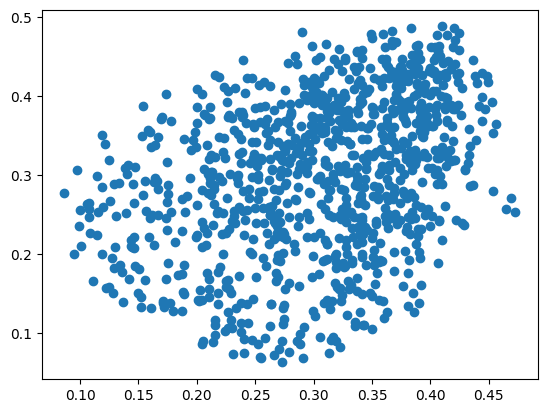

In [46]:
import matplotlib.pyplot as plt

plt.plot(dirichlet_res[:, :, 0], dirichlet_res[:, :, 1], 'o')

In [47]:
X

tensor([[0.4836, 0.3791, 0.1373],
        [0.4392, 0.4529, 0.1079],
        [0.1712, 0.4452, 0.3836],
        ...,
        [0.0858, 0.2088, 0.7054],
        [0.0937, 0.3179, 0.5884],
        [0.2892, 0.1805, 0.5303]])

In [38]:
dirichlet_res[:, 0, :]

tensor([[0.3675, 0.4698, 0.1578],
        [0.3032, 0.2952, 0.4114],
        [0.3313, 0.3395, 0.3383],
        ...,
        [0.1444, 0.2089, 0.6396],
        [0.2961, 0.2451, 0.4666],
        [0.4011, 0.3629, 0.2449]])

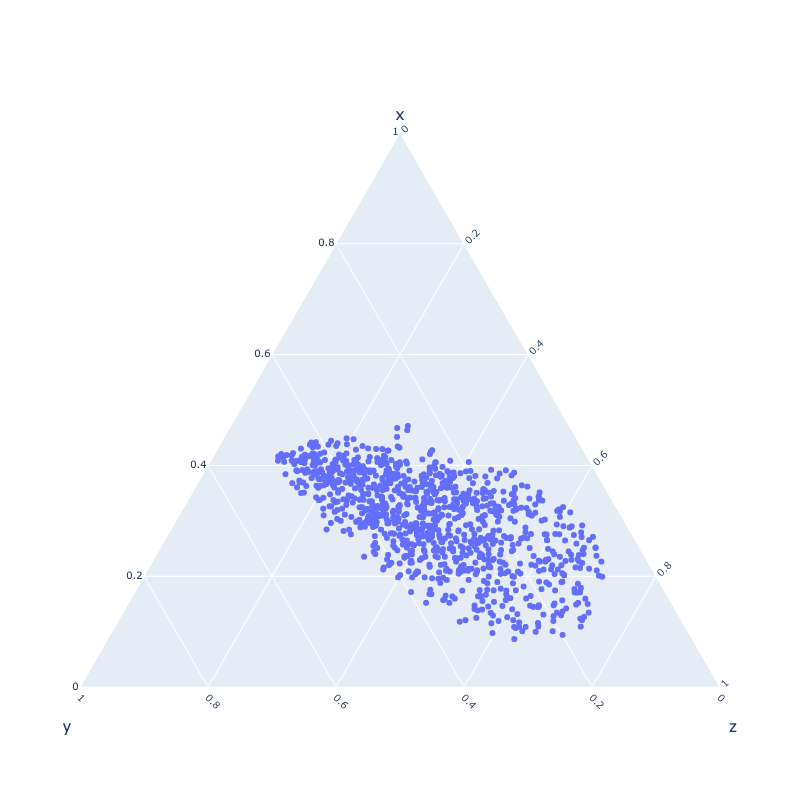

In [48]:
plot_ternary(dirichlet_res[:, 0, 0], dirichlet_res[:, 0,  1], dirichlet_res[:, 0, 2])

In [102]:
dirichlet_res

tensor([[[0.3675, 0.4698, 0.1578]],

        [[0.3032, 0.2952, 0.4114]],

        [[0.3313, 0.3395, 0.3383]],

        ...,

        [[0.1444, 0.2089, 0.6396]],

        [[0.2961, 0.2451, 0.4666]],

        [[0.4011, 0.3629, 0.2449]]])

# Learning the Swiss Roll on Simplex with Statistical Flow Matching

In this notebook, we demonstrate how to train SFM, SFM Naive, and LinearFM on the Swiss Roll dataset as a toy example. You will need to install `plotly` to visualize the results. Run `pip install plotly` to install it.

The Swiss Roll dataset is a 3-class dataset on the 2-simplex by normalizing the 2D Swiss roll to $[0+\varepsilon,1-\varepsilon]$ where $\varepsilon$ is a small margin.

In [198]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, Image
import numpy as np

from models import SphereCategoricalFlow, SimplexCategoricalFlow, LinearCategoricalFlow
from datasets.swissroll import make_swiss_roll
from utils import seed_all

We then define the vector field predictor, which is based on simple multi-layer perceptions (MLPs) on time embeddings and coordinates.

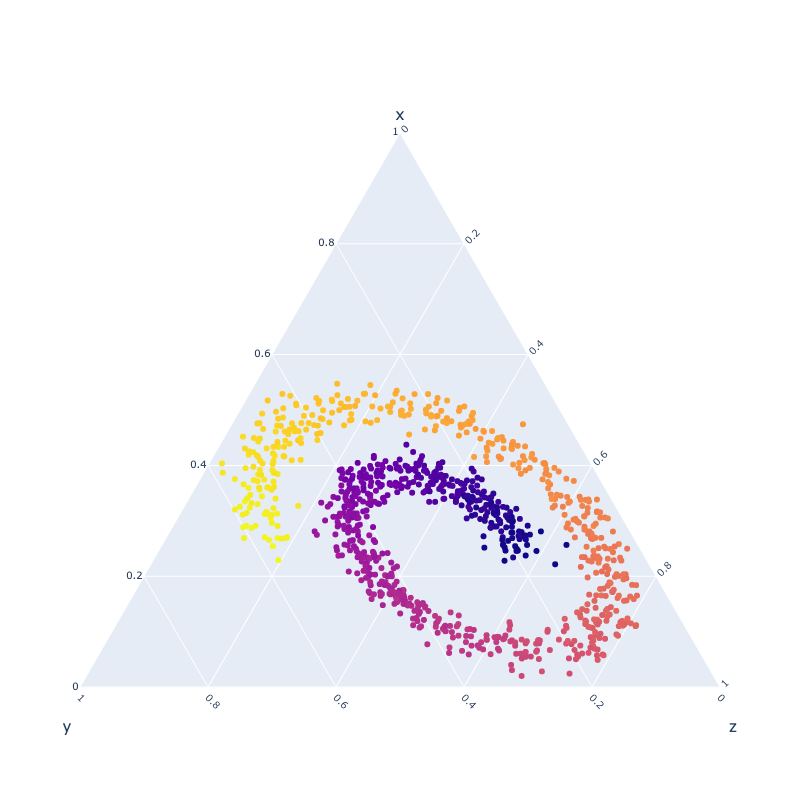

In [199]:
import plotly.graph_objects as go

static_fig = True


def makeAxis(title, tickangle):
    return {
        'title': title,
        'titlefont': {'size': 15},
        'tickangle': tickangle,
        'tickfont': {'size': 10},
        'tickcolor': 'rgba(0,0,0,0)',
        'ticklen': 5,
        'showline': True,
        'showgrid': True
    }


def plot_ternary(x, y, z, t=None):
    fig = go.Figure(go.Scatterternary({
        'mode': 'markers',
        'a': x,
        'b': y,
        'c': z,
        'marker': {
            'color': t,
        }
    }))
    fig.update_layout({
        'ternary': {
            'sum': 1,
            'aaxis': makeAxis('x', 0),
            'baxis': makeAxis('<br>y', 45),
            'caxis': makeAxis('<br>z', -45)
        },
        'annotations': [{
            'showarrow': False,
            'text': 'Ternary Plot',
            'x': 0.5,
            'y': 1.3,
            'font': {'size': 15}
        }],
        'width': 800,
        'height': 800,
    })
    if static_fig:
        display(Image(fig.to_image(format='png')))
    else:
        fig.show()


X, _t = make_swiss_roll(n_samples=1000, noise=1., pad=1., seed=42)
plot_ternary(X[:, 0], X[:, 1], X[:, 2], _t)

In [200]:
_t

tensor([13.0276, 13.3361,  8.3208, 13.7536,  8.3923, 10.3757,  7.1305, 12.1923,
        13.5790,  5.9676, 13.5208, 10.3067, 12.9063, 10.0630, 11.6970,  8.7594,
        13.0575, 10.1213,  7.2248, 10.6260,  7.2536,  8.8721,  7.5108, 12.5508,
         5.7050,  7.2523,  8.0941,  6.5913,  9.8695,  4.7704, 13.6806,  5.4218,
        13.0629, 10.2090,  7.8946, 12.3368, 10.1592, 13.2322,  9.9399,  7.9386,
        10.6909,  8.1469, 11.4080, 13.6321, 12.1488,  7.3647, 12.1451, 10.2679,
        11.8179,  6.5526,  4.7599,  7.6041,  5.8103, 13.2915, 10.7821, 11.3767,
        10.9151,  9.3428, 13.1127,  6.0766,  9.7215,  6.2084, 10.8779,  7.8019,
        10.8687,  8.4430, 13.3332,  6.6317,  6.6143,  6.6141, 13.6633, 10.9952,
        13.9593,  5.5358,  4.7507,  5.7380,  6.2548, 11.3335, 11.1122, 13.3404,
         6.9912,  6.2123, 11.9251,  7.5200, 12.2848,  8.3065, 12.1205,  5.7634,
         7.0467, 10.8615, 10.4210,  8.2233, 12.2337, 12.6283,  6.0075,  6.9090,
        13.7397,  7.8347,  7.7542,  4.86

In [230]:
import seaborn as sns
palette = sns.color_palette("icefire", 3)

In [193]:
np.save('ground_truth.npy', X)
np.save('ground_truth_t.npy', _t)
np.save('catflow.npy', final_state)
np.save('dirichlet.npy', dirichlet_res)
np.save('sfm.npy', SFM)

In [201]:
X = np.load('ground_truth.npy')
_t = np.load('ground_truth_t.npy')
final_state = np.load('catflow.npy')
dirichlet_res = np.load('dirichlet.npy')
SFM = np.load('sfm.npy')

In [214]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

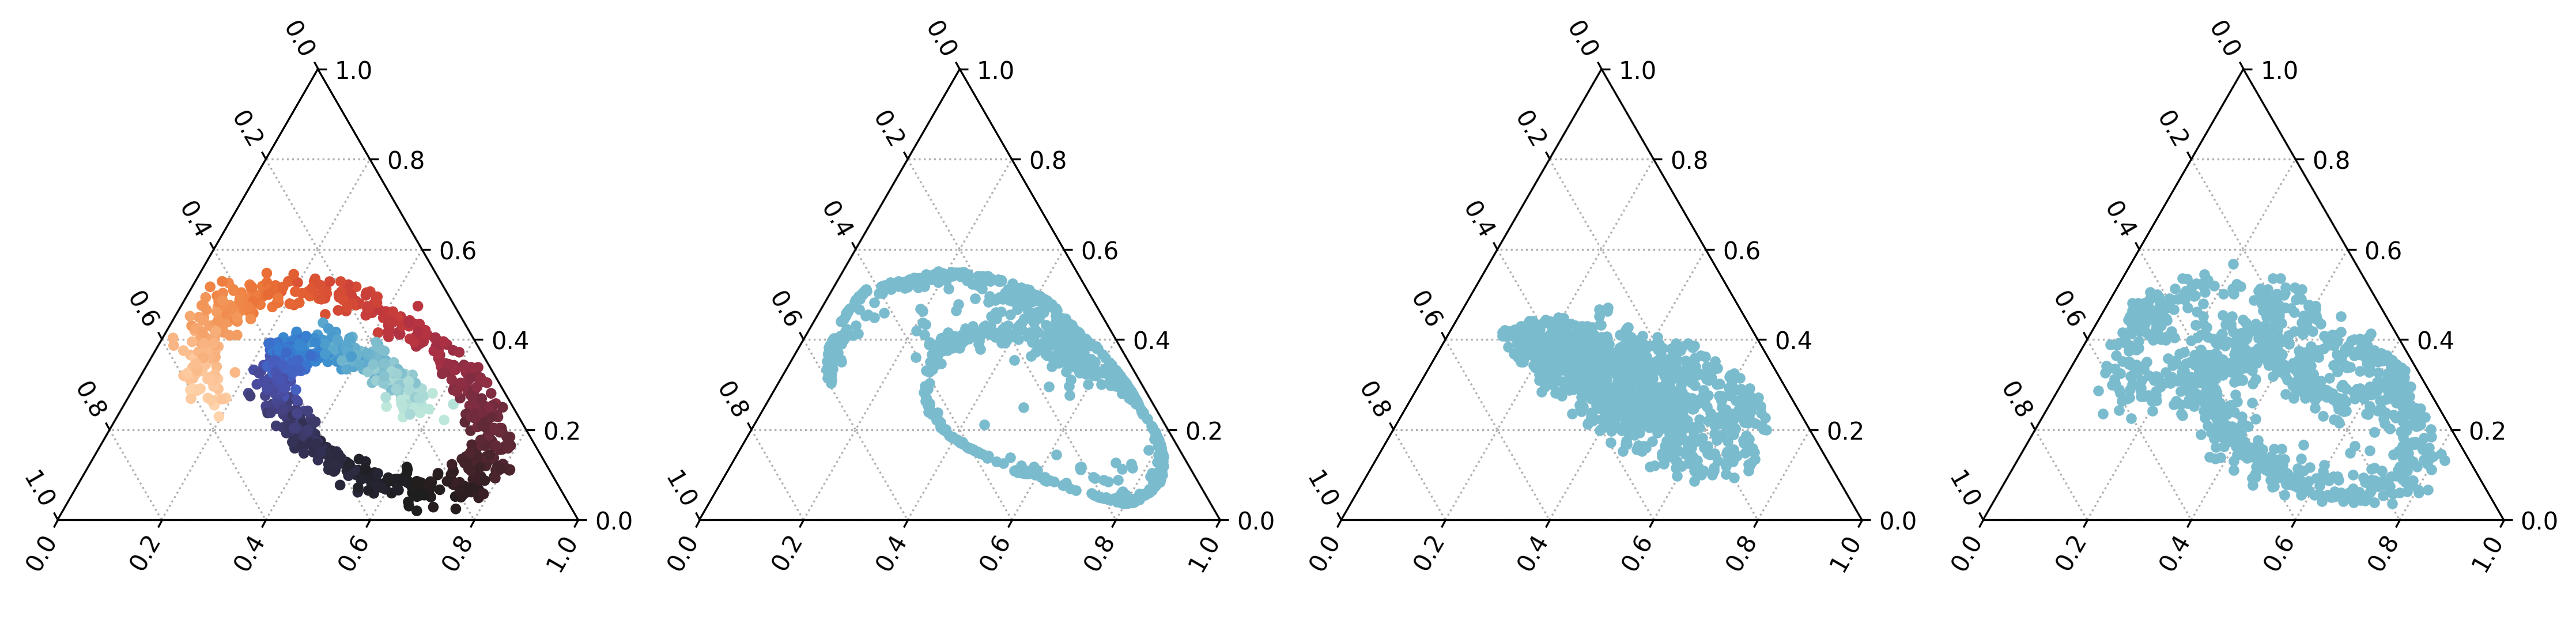

In [229]:
import numpy as np

import matplotlib.pyplot as plt
import mpltern
import seaborn as sns
pal = sns.color_palette("icefire", as_cmap=True)


np.random.seed(seed=19)
X, _t = make_swiss_roll(n_samples=1000, noise=1., pad=1., seed=42)

fig, axes = plt.subplots(1, 4, figsize=(15, 8), dpi=300, subplot_kw={'projection': 'ternary'})
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust space between subplots
# fig = plt.figure(figsize=(20.8, 10.8), dpi=800)
# fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)

#ax = fig.add_subplot(1, 4, 1, projection="ternary")
#ax1 = axes[0, 0]
ax1 = axes[0]
ax1.set_axisbelow(True)
ax1.grid(axis='l', which='both', linestyle=':')
ax1.grid(axis='t', which='both', linestyle=':')
ax1.grid(axis='r', which='both', linestyle=':')
#ax1.set_title("Ground Truth", fontsize=15, y=1.12)
ax1.set_title(" ", fontsize=15, y=-0.25)
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=_t, cmap=pal, s=20, alpha=1, edgecolors='black', linewidths=0)#.2)

#ax2 = axes[0, 1]
ax2 = axes[1]
ax2.set_axisbelow(True)
ax2.grid(axis='l', which='both', linestyle=':')
ax2.grid(axis='t', which='both', linestyle=':')
ax2.grid(axis='r', which='both', linestyle=':')
#ax2.set_title("CatFlow", fontsize=15, y=1.12)
ax2.set_title(" ", fontsize=15, y=-0.25)
ax2.scatter(final_state[:, 0], final_state[:, 1], final_state[:, 2], c=sns.color_palette("icefire", 10)[0], s=20, alpha=1, edgecolors='black', linewidths=0)#.2)

#ax3 = axes[1, 0]
ax3 = axes[2]
ax3.set_axisbelow(True)
ax3.grid(axis='l', which='both', linestyle=':')
ax3.grid(axis='t', which='both', linestyle=':')
ax3.grid(axis='r', which='both', linestyle=':')
ax3.set_title(" ", fontsize=15, y=-0.25)
ax3.scatter(dirichlet_res[:, 0, 0], dirichlet_res[:,0, 1], dirichlet_res[:,0, 2], c=sns.color_palette("icefire", 10)[0], s=20, alpha=1, edgecolors='black', linewidths=0)#.2)

#ax4 = axes[1, 1]
ax4 = axes[3]
ax4.set_axisbelow(True)
ax4.grid(axis='l', which='both', linestyle=':')
ax4.grid(axis='t', which='both', linestyle=':')
ax4.grid(axis='r', which='both', linestyle=':')
ax4.set_title(" ", fontsize=15, y=-0.25)
ax4.scatter(SFM[:, 0, 0], SFM[:,0, 1], SFM[:,0, 2], c=sns.color_palette("icefire", 10)[0], s=20, alpha=1, edgecolors='black', linewidths=0)#.2)

plt.tight_layout()
# save the plot
plt.savefig('swissroll_no_border.svg', dpi=900, bbox_inches='tight')

plt.show()

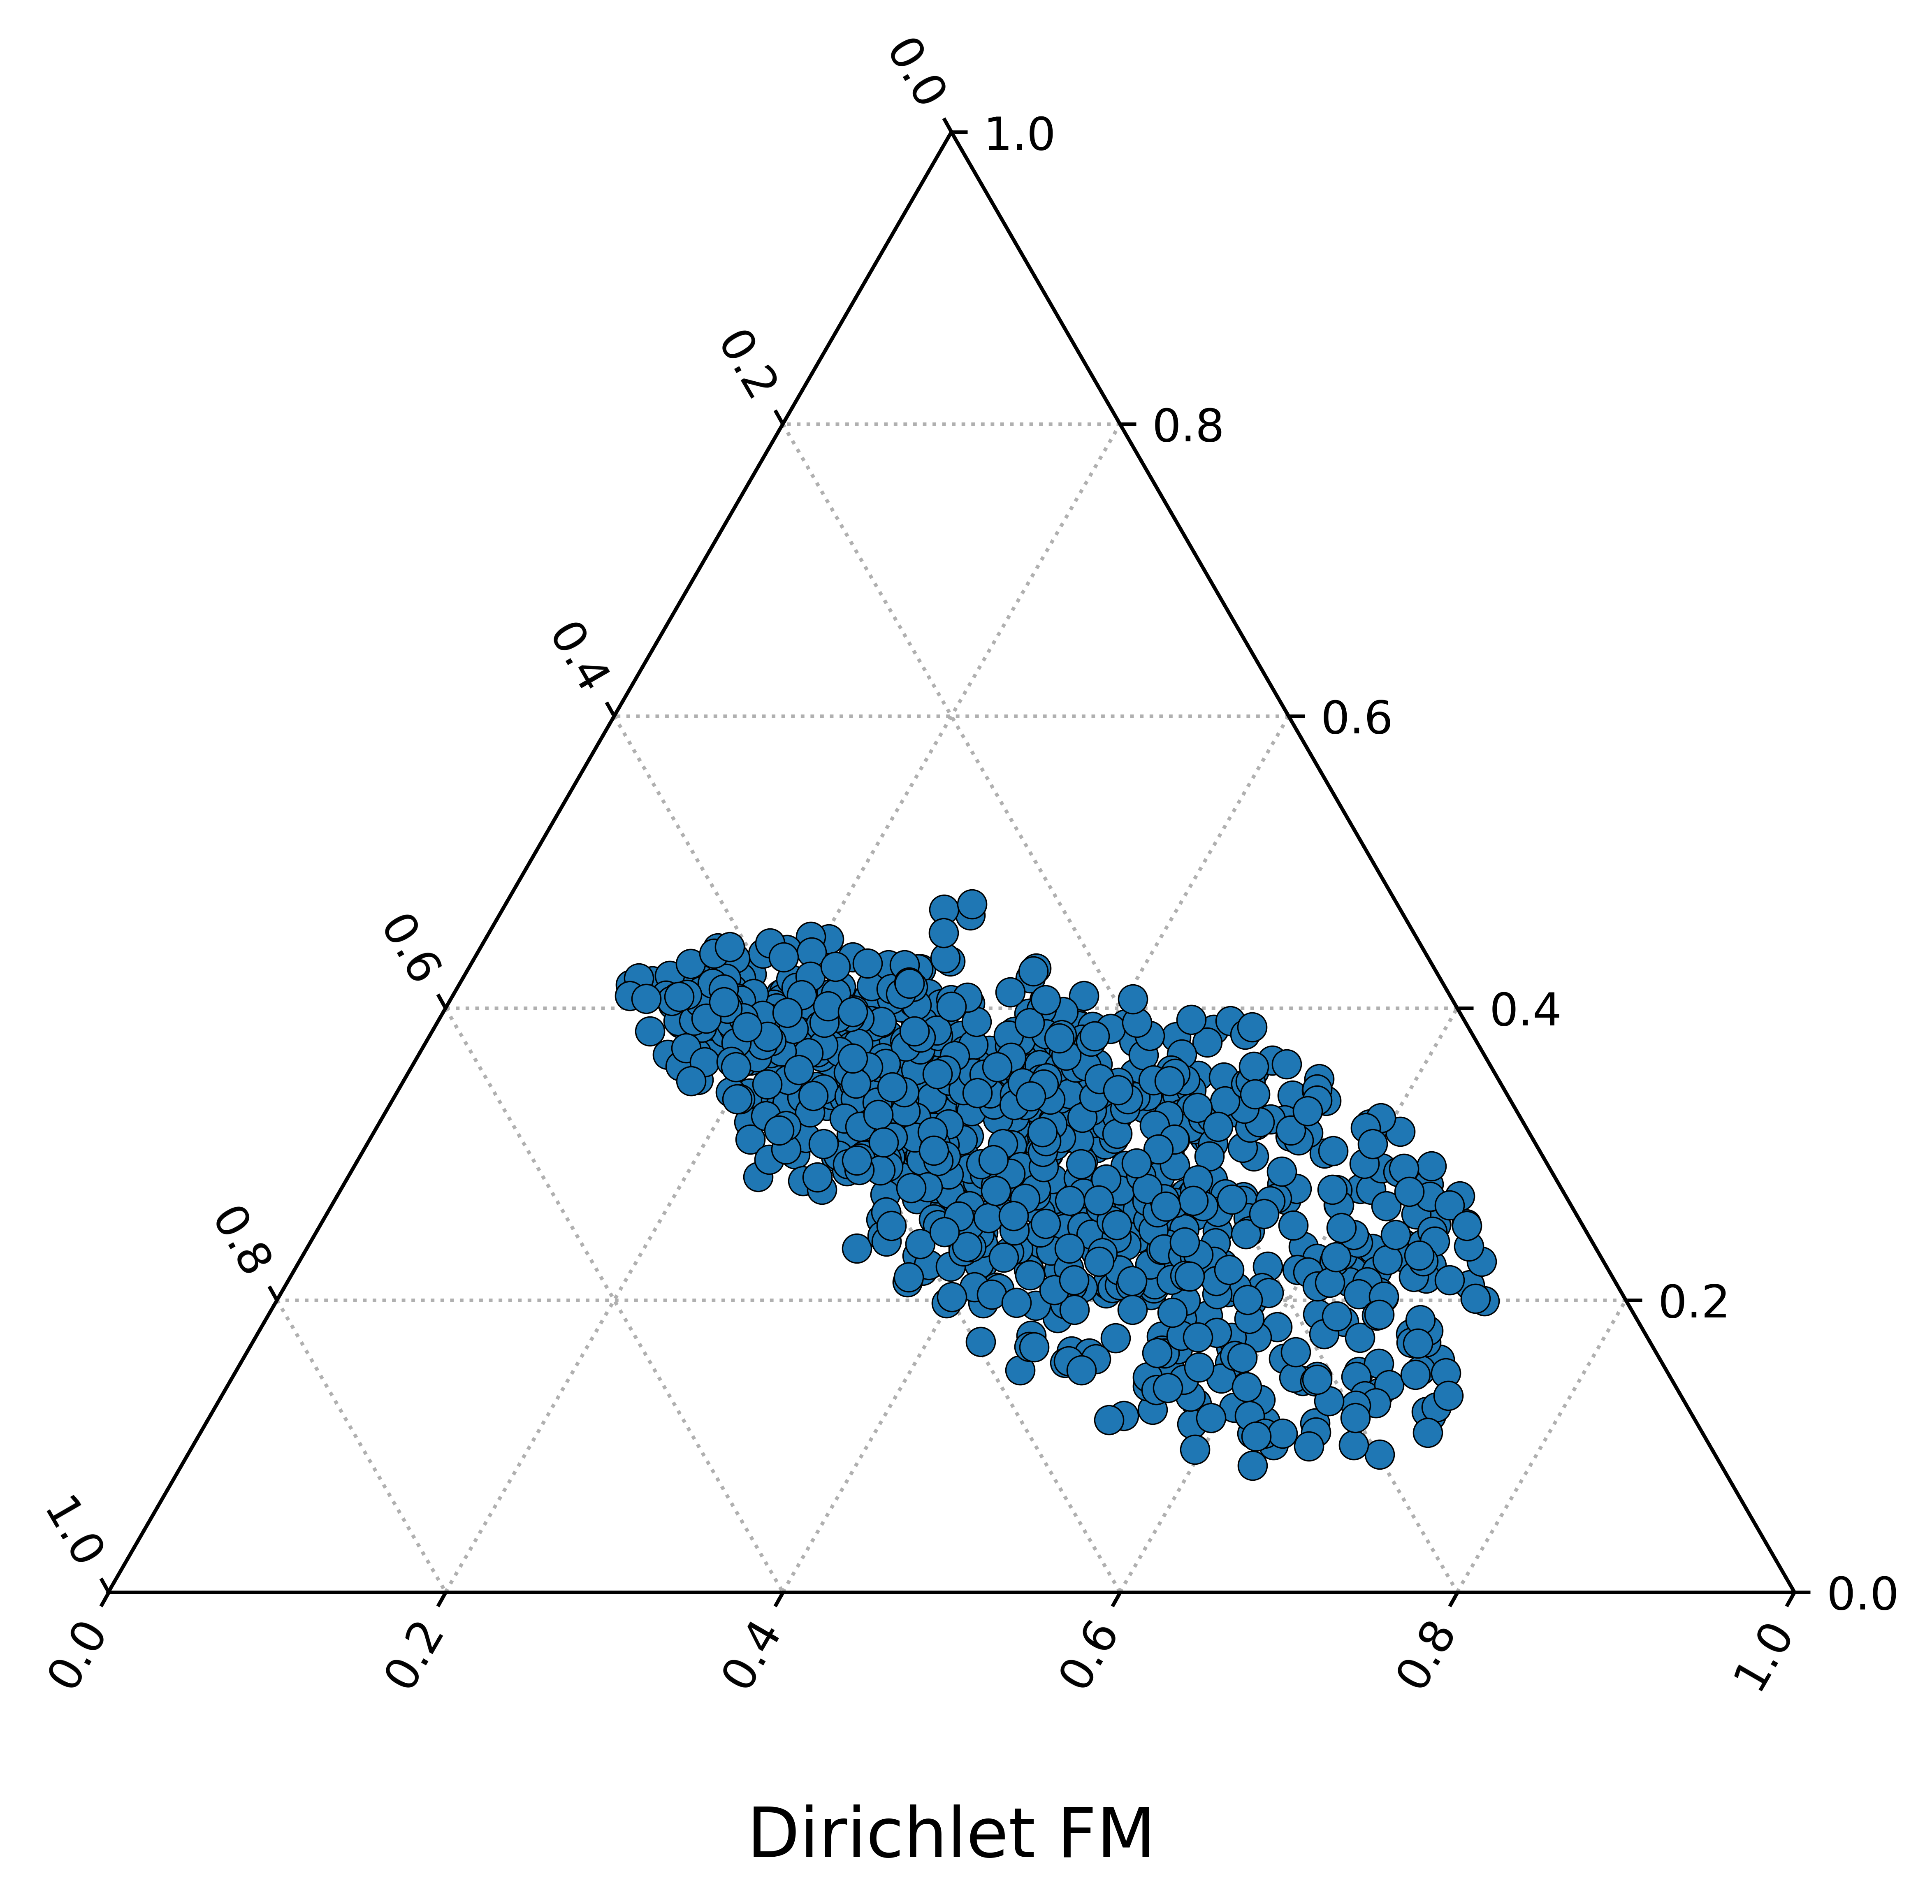

In [137]:
import numpy as np

import matplotlib.pyplot as plt
import mpltern
import seaborn as sns
pal = sns.color_palette("icefire", as_cmap=True)


np.random.seed(seed=19)
X, _t = make_swiss_roll(n_samples=1000, noise=1., pad=1., seed=42)


fig = plt.figure(figsize=(23.8, 10.8), dpi=800)
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)

ax = fig.add_subplot(1, 2, 1, projection="ternary")
ax.set_axisbelow(True)
ax.grid(axis='l', which='both', linestyle=':')
ax.grid(axis='t', which='both', linestyle=':')
ax.grid(axis='r', which='both', linestyle=':')
ax.set_title("Dirichlet FM", fontsize=15, y=-0.2)
pc = ax.scatter(dirichlet_res[:, 0, 0], dirichlet_res[:,0, 1], dirichlet_res[:,0, 2], cmap=pal, s=40, alpha=1, edgecolors='black', linewidths=0.3)


plt.show()

In [150]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


def train(model, n_epoch=2000, lr=1e-3, log_epoch=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epoch):
        model.train()
        optimizer.zero_grad()
        loss = model.get_loss(X.unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()
        if epoch % log_epoch == 0:
            print(f'Epoch {epoch}, loss {loss.item():.4f}')
            model.eval()
            with torch.no_grad():
                nll = model.compute_nll_ode(X.unsqueeze(1).to(device), 500, verbose=False)
                print(f'NLL: {nll.item():.4f}')
    print('Done!')


def sample(model, n_sample=1000, method='ode', n_step=1000):
    model.eval()
    with torch.no_grad():
        X_gen = model.sample(method, n_sample, n_step, device).detach().cpu().numpy()
    return X_gen
    plot_ternary(X_gen[:, 0, 0], X_gen[:, 0, 1], X_gen[:, 0, 2])


def cal_nll(model, n_repeat=20, method='ode', n_step=500):
    nlls = []
    model.eval()
    with torch.no_grad():
        for _ in range(n_repeat):
            nll = model.compute_nll(method, X.unsqueeze(1).to(device), n_step)
            nlls.append(nll.item())
            print(f'NLL: {sum(nlls) / len(nlls):.4f}')
    nlls = np.array(nlls)
    print(f'Avg NLL: {nlls.mean():.4f} ± {nlls.std():.4f}')

## SFM

We train the SFM model on the Swiss Roll dataset and calculate the negative log-likelihood (NLL). SFM utilizes the diffeomorphism between the 2-simplex and the 2-sphere as:
$$
\pi: \mathcal{P} \to S_+^{n-1}, \quad \mu_i \mapsto x_i=\sqrt{\mu_i}.
$$

In [149]:
SFM

In [151]:
seed_all(42)
sfm = SphereCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(sfm, 2000)
SFM = sample(sfm, 1000, 'ode')

Epoch 0, loss 0.2263
NLL: -0.6870
Epoch 200, loss 0.1610
NLL: -1.8304
Epoch 400, loss 0.1517
NLL: -1.8860
Epoch 600, loss 0.1499
NLL: -2.0804
Epoch 800, loss 0.1566
NLL: -2.1066
Epoch 1000, loss 0.1454
NLL: -2.1720
Epoch 1200, loss 0.1429
NLL: -2.2000
Epoch 1400, loss 0.1444
NLL: -2.2464
Epoch 1600, loss 0.1429
NLL: -2.3130
Epoch 1800, loss 0.1503
NLL: -2.2894
Done!


Epoch 0, loss 0.2263
NLL: -0.6870
Epoch 200, loss 0.1610
NLL: -1.8304
Epoch 400, loss 0.1517
NLL: -1.8860
Epoch 600, loss 0.1499
NLL: -2.0804
Epoch 800, loss 0.1566
NLL: -2.1066
Epoch 1000, loss 0.1454
NLL: -2.1720
Epoch 1200, loss 0.1429
NLL: -2.2000
Epoch 1400, loss 0.1444
NLL: -2.2464
Epoch 1600, loss 0.1429
NLL: -2.3130
Epoch 1800, loss 0.1503
NLL: -2.2894
Done!


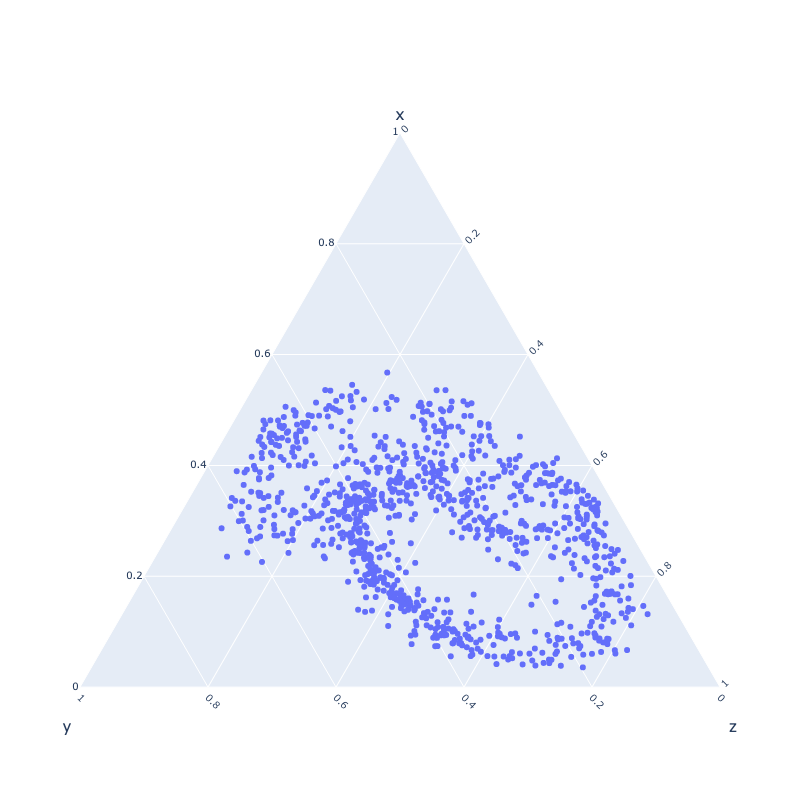

In [6]:
seed_all(42)
sfm = SphereCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(sfm, 2000)
sample(sfm, 1000, 'ode')

In [7]:
cal_nll(sfm, 20, method='ode')
nll = sfm.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -2.5514
NLL: -2.5381
NLL: -2.5199
NLL: -2.5393
NLL: -2.5341
NLL: -2.5469
NLL: -2.5456
NLL: -2.5585
NLL: -2.5460
NLL: -2.5472
NLL: -2.5377
NLL: -2.5328
NLL: -2.5317
NLL: -2.5284
NLL: -2.5320
NLL: -2.5296
NLL: -2.5316
NLL: -2.5407
NLL: -2.5435
NLL: -2.5411
Avg NLL: -2.5411 ± 0.0649
logp0: 0.6931, logdetjac: 2.2061, logt0: -0.8905, logt1: 0.5216
Exact NLL: -2.5304


In [7]:
cal_nll(sfm, 20, method='ode')
nll = sfm.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -2.1970
NLL: -2.1902
NLL: -2.2110
NLL: -2.2318
NLL: -2.2495
NLL: -2.2555
NLL: -2.2686
NLL: -2.2601
NLL: -2.2512
NLL: -2.2434
NLL: -2.2437
NLL: -2.2550
NLL: -2.2543
NLL: -2.2587
NLL: -2.2609
NLL: -2.2687
NLL: -2.2657
NLL: -2.2665
NLL: -2.2728
NLL: -2.2683
Avg NLL: -2.2683 ± 0.0698
logp0: 0.6931, logdetjac: 2.1349, logt0: -1.0551, logt1: 0.5216
Exact NLL: -2.2946


## SFM Naive

In the naive version of SFM, we directly work with the statistical manifold of categorical distributions and uses the exponential and logarithm maps for training the flow.

Epoch 0, loss 0.9054
NLL: -0.7083
Epoch 200, loss 0.6636
NLL: -1.3900
Epoch 400, loss 0.6297
NLL: -1.5728
Epoch 600, loss 0.6227
NLL: -1.6129
Epoch 800, loss 0.6611
NLL: -1.6549
Epoch 1000, loss 0.6102
NLL: -1.6638
Epoch 1200, loss 0.5953
NLL: -1.6402
Epoch 1400, loss 0.5932
NLL: -1.6322
Epoch 1600, loss 0.5910
NLL: -1.6406
Epoch 1800, loss 0.6193
NLL: -1.6125
Done!


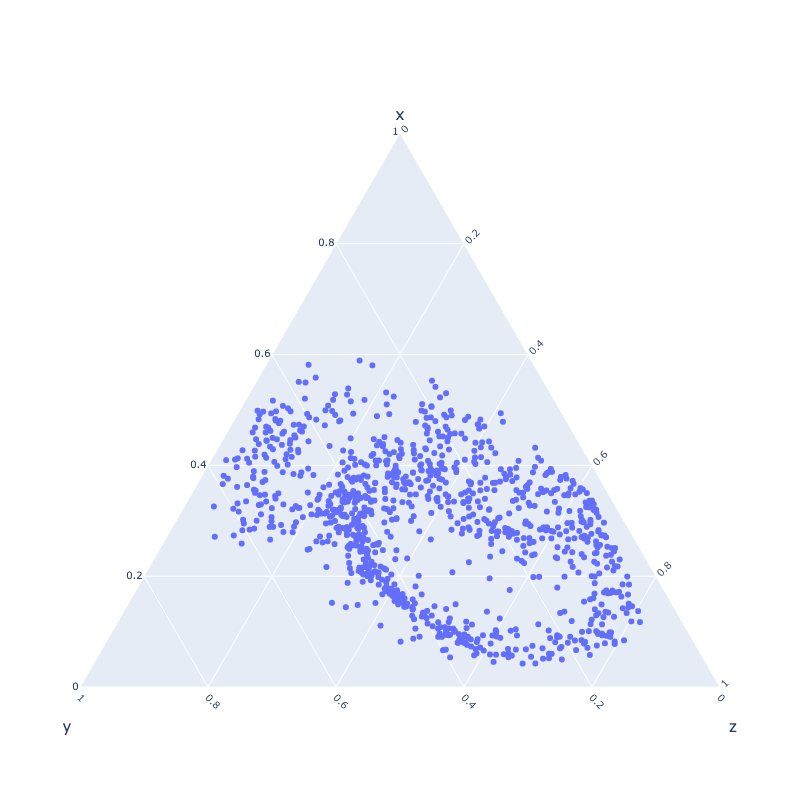

In [8]:
seed_all(42)
sfm_simplex = SimplexCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(sfm_simplex, 2000)
sample(sfm_simplex, 1000, 'ode')

In [9]:
cal_nll(sfm_simplex, 20, method='ode')
nll = sfm_simplex.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -1.8145
NLL: -1.8034
NLL: -1.7878
NLL: -1.8003
NLL: -1.7872
NLL: -1.7942
NLL: -1.7979
NLL: -1.8120
NLL: -1.7982
NLL: -1.7970
NLL: -1.7894
NLL: -1.7862
NLL: -1.7813
NLL: -1.7746
NLL: -1.7735
NLL: -1.7702
NLL: -1.7712
NLL: -1.7808
NLL: -1.7850
NLL: -1.7807
Avg NLL: -1.7807 ± 0.0701
logp0: 0.6931, logdetjac: 1.0832, logt0: 0.0000, logt1: 0.0000
Exact NLL: -1.7763


## LinearFM

The linear flow matching model simply assumes an underlying Euclidean structure for the manifold of categorical distributions.

Epoch 0, loss 0.2445
NLL: -0.7078
Epoch 200, loss 0.1672
NLL: -1.5725
Epoch 400, loss 0.1548
NLL: -1.7000
Epoch 600, loss 0.1552
NLL: -1.6889
Epoch 800, loss 0.1620
NLL: -1.7795
Epoch 1000, loss 0.1563
NLL: -1.7213
Epoch 1200, loss 0.1515
NLL: -1.6876
Epoch 1400, loss 0.1501
NLL: -1.7284
Epoch 1600, loss 0.1476
NLL: -1.7299
Epoch 1800, loss 0.1551
NLL: -1.8015
Done!


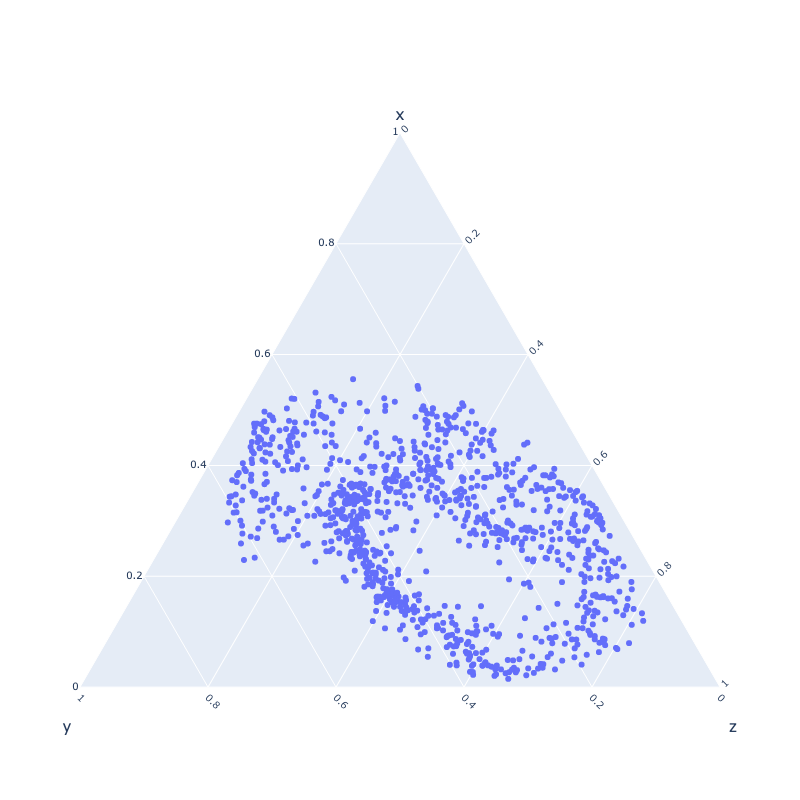

In [10]:
seed_all(42)
lfm = LinearCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(lfm, 2000)
sample(lfm, 1000, 'ode')

In [11]:
cal_nll(lfm, 20, method='ode')
nll = lfm.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -1.8053
NLL: -1.8414
NLL: -1.8351
NLL: -1.8377
NLL: -1.8177
NLL: -1.8250
NLL: -1.8266
NLL: -1.8425
NLL: -1.8267
NLL: -1.8286
NLL: -1.8167
NLL: -1.8110
NLL: -1.8066
NLL: -1.7964
NLL: -1.7929
NLL: -1.7891
NLL: -1.7925
NLL: -1.8025
NLL: -1.8065
NLL: -1.8026
Avg NLL: -1.8026 ± 0.0830
logp0: 0.6931, logdetjac: 1.1057, logt0: 0.0000, logt1: 0.0000
Exact NLL: -1.7989


Dirichlet FM

In [239]:
atoms_stable = np.array([0.9926760563380281, 0.9927560459155244, 0.9923203510696654]) * 100
mol_stable = np.array([0.89, 0.898, 0.89]) * 100
valid_mols = np.array([0.91, 0.922, 0.91]) * 100

In [240]:
np.mean(atoms_stable), np.mean(mol_stable), np.mean(valid_mols)

(np.float64(99.25841511077392),
 np.float64(89.26666666666667),
 np.float64(91.39999999999999))

In [241]:
np.std(atoms_stable), np.std(mol_stable), np.std(valid_mols)

(np.float64(0.018937164200380927),
 np.float64(0.377123616632824),
 np.float64(0.5656854249492393))

In [242]:
# CatFlow

atoms_stable = np.array([0.9950276243093923, 0.9933407325194229, 0.995575221238938]) * 100
mol_stable = np.array([0.92, 0.88, 0.92]) * 100
valid_mols = np.array([0.95, 0.91, 0.97]) * 100

In [243]:
np.mean(atoms_stable), np.mean(mol_stable), np.mean(valid_mols)

(np.float64(99.46478593559176),
 np.float64(90.66666666666667),
 np.float64(94.33333333333333))

In [244]:
np.std(atoms_stable), np.std(mol_stable), np.std(valid_mols)

(np.float64(0.09509297290286663),
 np.float64(1.8856180831641267),
 np.float64(2.494438257849294))